# 🕵️‍♂️ BLUESENSE ECG: The Great Data Detective Story
## Dirty (BedMaster) vs. Clean (Lead II) Comparison

**Goal:** Understand *why* our cleaning pipeline matters by visualizing the difference step-by-step.

### Why did the values look the same before?
Great question! If you opened the CSVs and they looked similar, it might be because:
1.  **Sampling:** Maybe you looked at a clean section of the dirty file?
2.  **Source Confusion:** The HDF5 file has *many* datasets. `bedmaster/vitals/hr/value` is the monitor's guess, but `bedmaster/waveforms/ii/value` is the raw signal we cleaned. 

In this notebook, we will explicitly pull the **Monitor's Guess (Dirty)** and compare it against **Our Algorithm (Clean)**.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

# Add B/src to path to import b_hrv
sys.path.append(os.path.abspath('../src'))
import b_hrv

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]

## Step 1: Load the "Dirty" Data (BedMaster Monitor)
This is what the hospital monitor *thought* the heart rate was. It's often full of errors because monitors prioritize "showing a number" over accuracy.

In [2]:
H5_PATH = "../data/raw/3254689660.hd5"

with h5py.File(H5_PATH, 'r') as f:
    # We grab the Heart Rate (HR) stream directly from the monitor
    hr_dirty_bpm = f['bedmaster/vitals/hr/value'][:20000] # First 20k samples
    
    # Convert BPM to RR intervals (ms)
    # Formula: RR(ms) = 60000 / HR(bpm)
    # We filter out 0s to avoid division by zero errors
    valid_mask = hr_dirty_bpm > 0
    rr_dirty_ms = 60000.0 / hr_dirty_bpm[valid_mask]

print(f"Loaded {len(rr_dirty_ms)} dirty beats.")
print(f"First 5 dirty RR values: {rr_dirty_ms[:5]}")

Loaded 20000 dirty beats.
First 5 dirty RR values: [769.23076923 759.49367089 769.23076923 769.23076923 779.22077922]


## Step 2: Load the "Clean" Data (Our Lead II Algorithm)
This is the data we painstakingly extracted and cleaned in Stage A.

In [3]:
CSV_PATH = "../../A/results/lead_II_FINAL/cleaned_rr.csv"

df = pd.read_csv(CSV_PATH)
rr_clean_ms = df['RR_next_ms'].dropna().values

print(f"Loaded {len(rr_clean_ms)} clean beats.")
print(f"First 5 clean RR values: {rr_clean_ms[:5]}")

Loaded 24550 clean beats.
First 5 clean RR values: [770.83333333 770.83333333 783.33333333 787.5        787.5       ]


## Step 3: Visual Inspection (The "Eye Test")
Let's plot the raw values over time. Do they look stable or chaotic?

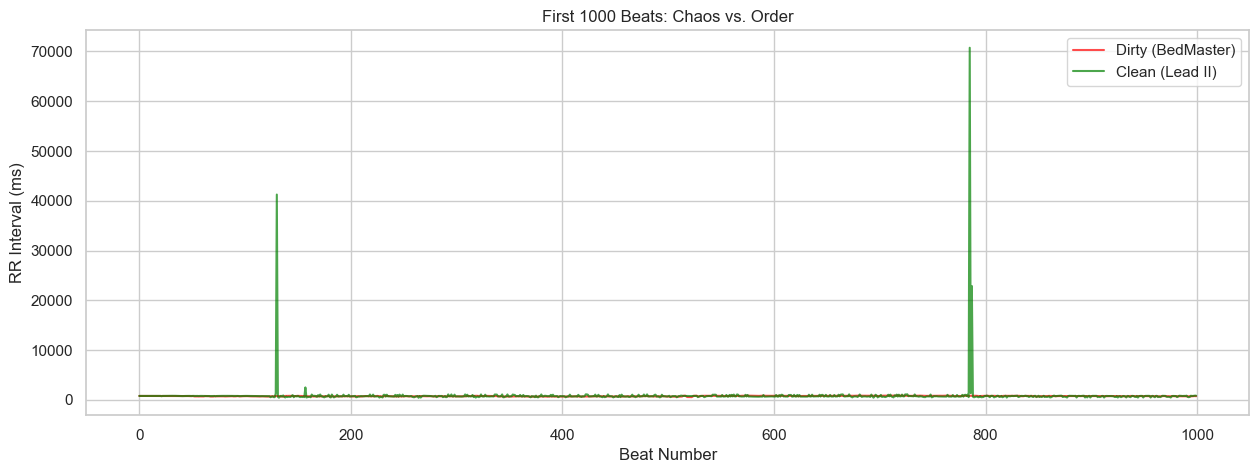

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(rr_dirty_ms[:1000], label='Dirty (BedMaster)', alpha=0.7, color='red')
plt.plot(rr_clean_ms[:1000], label='Clean (Lead II)', alpha=0.7, color='green')
plt.title("First 1000 Beats: Chaos vs. Order")
plt.ylabel("RR Interval (ms)")
plt.xlabel("Beat Number")
plt.legend()
plt.show()

## Step 4: Run the Analysis Engine (`b_hrv`)
Now we feed both datasets into our analysis brain.

In [5]:
summary_dirty, _ = b_hrv.analyze_rr(rr_dirty_ms)
summary_clean, _ = b_hrv.analyze_rr(rr_clean_ms)

/Users/barko/Desktop/BLUESENSE/OPIOID_OVERDOSE/B/src/b_hrv.py:451: UserWarning: RR series short for robust DFA; results may be unstable.
  warnings.warn("RR series short for robust DFA; results may be unstable.")


## Step 5: Detailed Comparison
Let's look at more than just RMSSD. We'll check:
1.  **RMSSD:** Parasympathetic (Vagus) activity. (Sensitive to noise!)
2.  **SDNN:** Overall variability.
3.  **pNN50:** Another measure of irregularity.
4.  **Mean HR:** Did cleaning change the average heart rate?
5.  **Entropy (SampEn):** Complexity/Chaos measure.

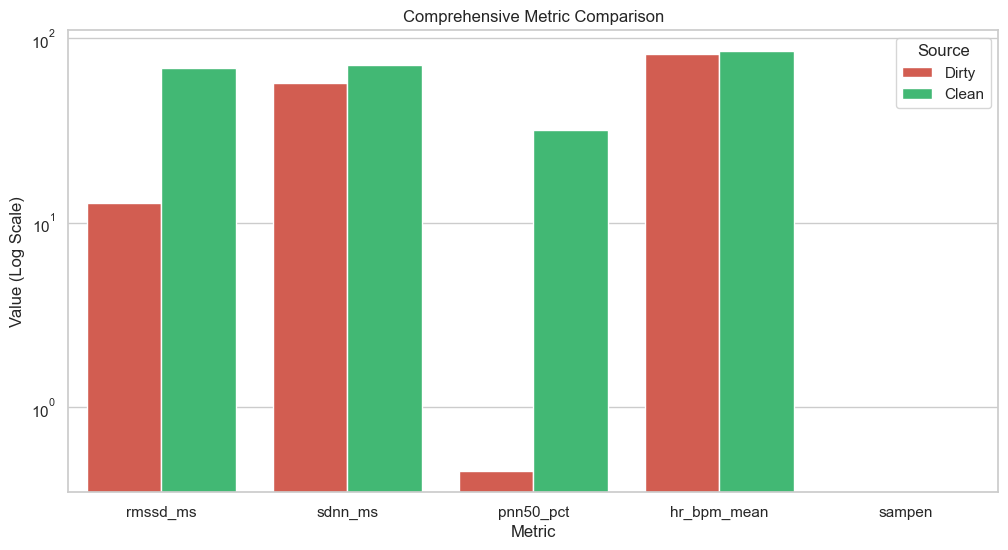

In [6]:
metrics = ['rmssd_ms', 'sdnn_ms', 'pnn50_pct', 'hr_bpm_mean', 'sampen']
data = []

for m in metrics:
    # Extract from nested dictionaries
    val_dirty = summary_dirty['time_domain'].get(m, 
                summary_dirty['freq_domain'].get(m, 
                summary_dirty['nonlinear'].get(m, 0)))
    
    val_clean = summary_clean['time_domain'].get(m, 
                summary_clean['freq_domain'].get(m, 
                summary_clean['nonlinear'].get(m, 0)))
    
    data.append({'Metric': m, 'Value': val_dirty, 'Source': 'Dirty'})
    data.append({'Metric': m, 'Value': val_clean, 'Source': 'Clean'})

df_comp = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_comp, x='Metric', y='Value', hue='Source', palette=['#e74c3c', '#2ecc71'])
plt.title("Comprehensive Metric Comparison")
plt.yscale('log') # Log scale to see small and large values together
plt.ylabel("Value (Log Scale)")
plt.show()

### Interpretation
*   **RMSSD:** Look at the huge drop! The dirty data had massive jumps (noise) that inflated this value falsely.
*   **SampEn (Entropy):** Dirty data is usually more "random" (higher entropy) due to noise. Clean data shows the true physiological complexity.

## Step 6: The Poincaré Plot (The Truth Teller)
This plot shows every beat against the next one. It reveals the "shape" of the heart rhythm.

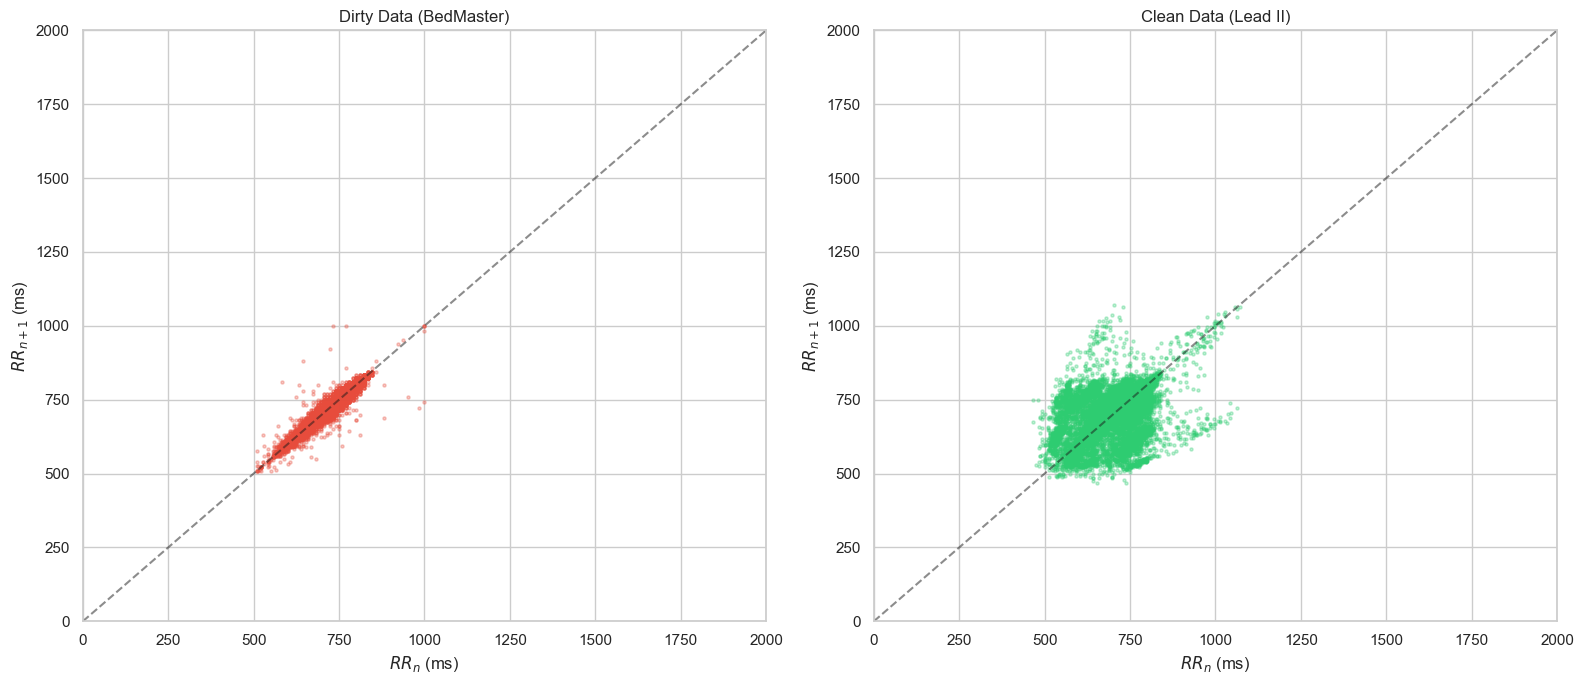

In [7]:
def plot_poincare(rr, title, ax, color):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]
    ax.scatter(rr_n, rr_n1, alpha=0.3, s=5, c=color)
    ax.set_xlabel('$RR_n$ (ms)')
    ax.set_ylabel('$RR_{n+1}$ (ms)')
    ax.set_title(title)
    ax.set_xlim(0, 2000)
    ax.set_ylim(0, 2000)
    ax.plot([0, 2000], [0, 2000], 'k--', alpha=0.5)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

plot_poincare(summary_dirty['rr_used_ms'], 'Dirty Data (BedMaster)', axes[0], '#e74c3c')
plot_poincare(summary_clean['rr_used_ms'], 'Clean Data (Lead II)', axes[1], '#2ecc71')

plt.tight_layout()
plt.show()